# GPT Image Description Lab

Welcome! This mini-lab turns any uploaded photo into a clear summary using OpenAI's latest vision model.

Objectives:
- Generate image descriptions using a vision model  
- Construct multimodal prompts (text + image)  
- Handle image uploads and base64 encoding  
- Build a simple Gradio UI for image analysis

## Game Plan
- **Context:** We run everything in Google Colab so setup stays simple.
- **Model:** `gpt-5-mini` handles multimodal prompts at low latency.
- **Secret management:** Grab the API key from the Colab `userdata` vault.
- **Flow:** upgrade packages → import helpers → load the key → spin up the client → describe images via helper + Gradio.
- **Stretch idea:** adjust the prompt to emphasize objects, colors, or business context.

## Imports & Constants
Set up everything we need for image uploads, encoding, and model calls.

In [ ]:
from google.colab import userdata
import base64
import os
from io import BytesIO
import requests

import gradio as gr
from openai import OpenAI
import PIL
from IPython.display import Markdown, display, Image

MODEL = "gpt-5-mini"
DEFAULT_PROMPT = "Describe the main subjects, and setting of this image."
VISION_INSTRUCTIONS = """
You are Professor Owl, a wise but approachable Business Analytics teacher.
Describe technical images clearly and accurately, using a structured style helpful for students analyzing technical visuals.

For each image:
- Begin with a concise overview of what the image represents.
- Identify key objects, components, or entities in the scene.
- Describe their positions, shapes, colors, and spatial relationships.
- Explain any technical elements: charts, dashboards, diagrams, code snippets, UI screens, data tables, ER diagrams, workflows, architecture diagrams, or analytic visualizations.

When describing ER diagrams specifically:
- Identify all entities and list their attributes.
- Note primary keys, foreign keys, and important fields.
- Describe relationships between entities and specify cardinalities (1–1, 1–many, many–many).
- Explain how the entities connect and what the diagram structure implies.

For charts and data visuals:
- Describe axes, labels, scales, data points, trends, outliers, and patterns.

Keep the tone warm and encouraging, like a helpful professor, but prioritize precision and clarity.
Do not guess or invent information—describe only what is visually present.
Your goal is to help students deeply understand diagrams, charts, models, dashboards, and other analytics-focused images.
And finally, if you have any suggestions to improve the chart, especially in case of data visualization and ERDs please lay them out clearly at the end.
Do not offer to redraw or other suggestions that you are not able to implement.
"""

## Load Secrets (No Hard-Coding!)
Keys stay in the Colab `userdata` vault. Set the environment variable so the SDK picks it up automatically.

In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get("OpenAI_API_Key")

## Initialize the GPT Vision Client
We create a single reusable client instance for the rest of the notebook.

In [ ]:
client = OpenAI()

## Helper: Describe an Image
The helper converts the PIL image to base64, calls `gpt-image-1-mini`, and returns both the description and token usage.

In [ ]:
def _image_to_base64(image):
    if image is None:
        raise ValueError("An image is required.")
    if image.mode != "RGB":
        image = image.convert("RGB")
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")


def describe_image(image, prompt=DEFAULT_PROMPT):
    if image is None:
        return "Please upload an image first.", {}

    try:
        encoded_image = _image_to_base64(image)
        prompt_text = prompt.strip() or DEFAULT_PROMPT

        response = client.responses.create(
            model=MODEL,
            instructions=VISION_INSTRUCTIONS,
            input=[
                {
                    "role": "user",
                    "content": [
                        {"type": "input_text", "text": prompt_text},
                        {
                            "type": "input_image",
                            "image_url": f"data:image/jpeg;base64,{encoded_image}",
                        },
                    ],
                }
            ],
            text={"verbosity": "low"},
        )

        usage = response.usage
        usage_report = {
            "input_tokens": getattr(usage, "input_tokens", None),
            "output_tokens": getattr(usage, "output_tokens", None),
            "total_tokens": getattr(usage, "total_tokens", None),
        }

        return response.output_text.strip(), usage_report

    except Exception as exc:
        return f"OpenAI error: {exc}", {}

## Quick Sanity Check (Optional)
Use this helper to try a local file path before launching the UI.

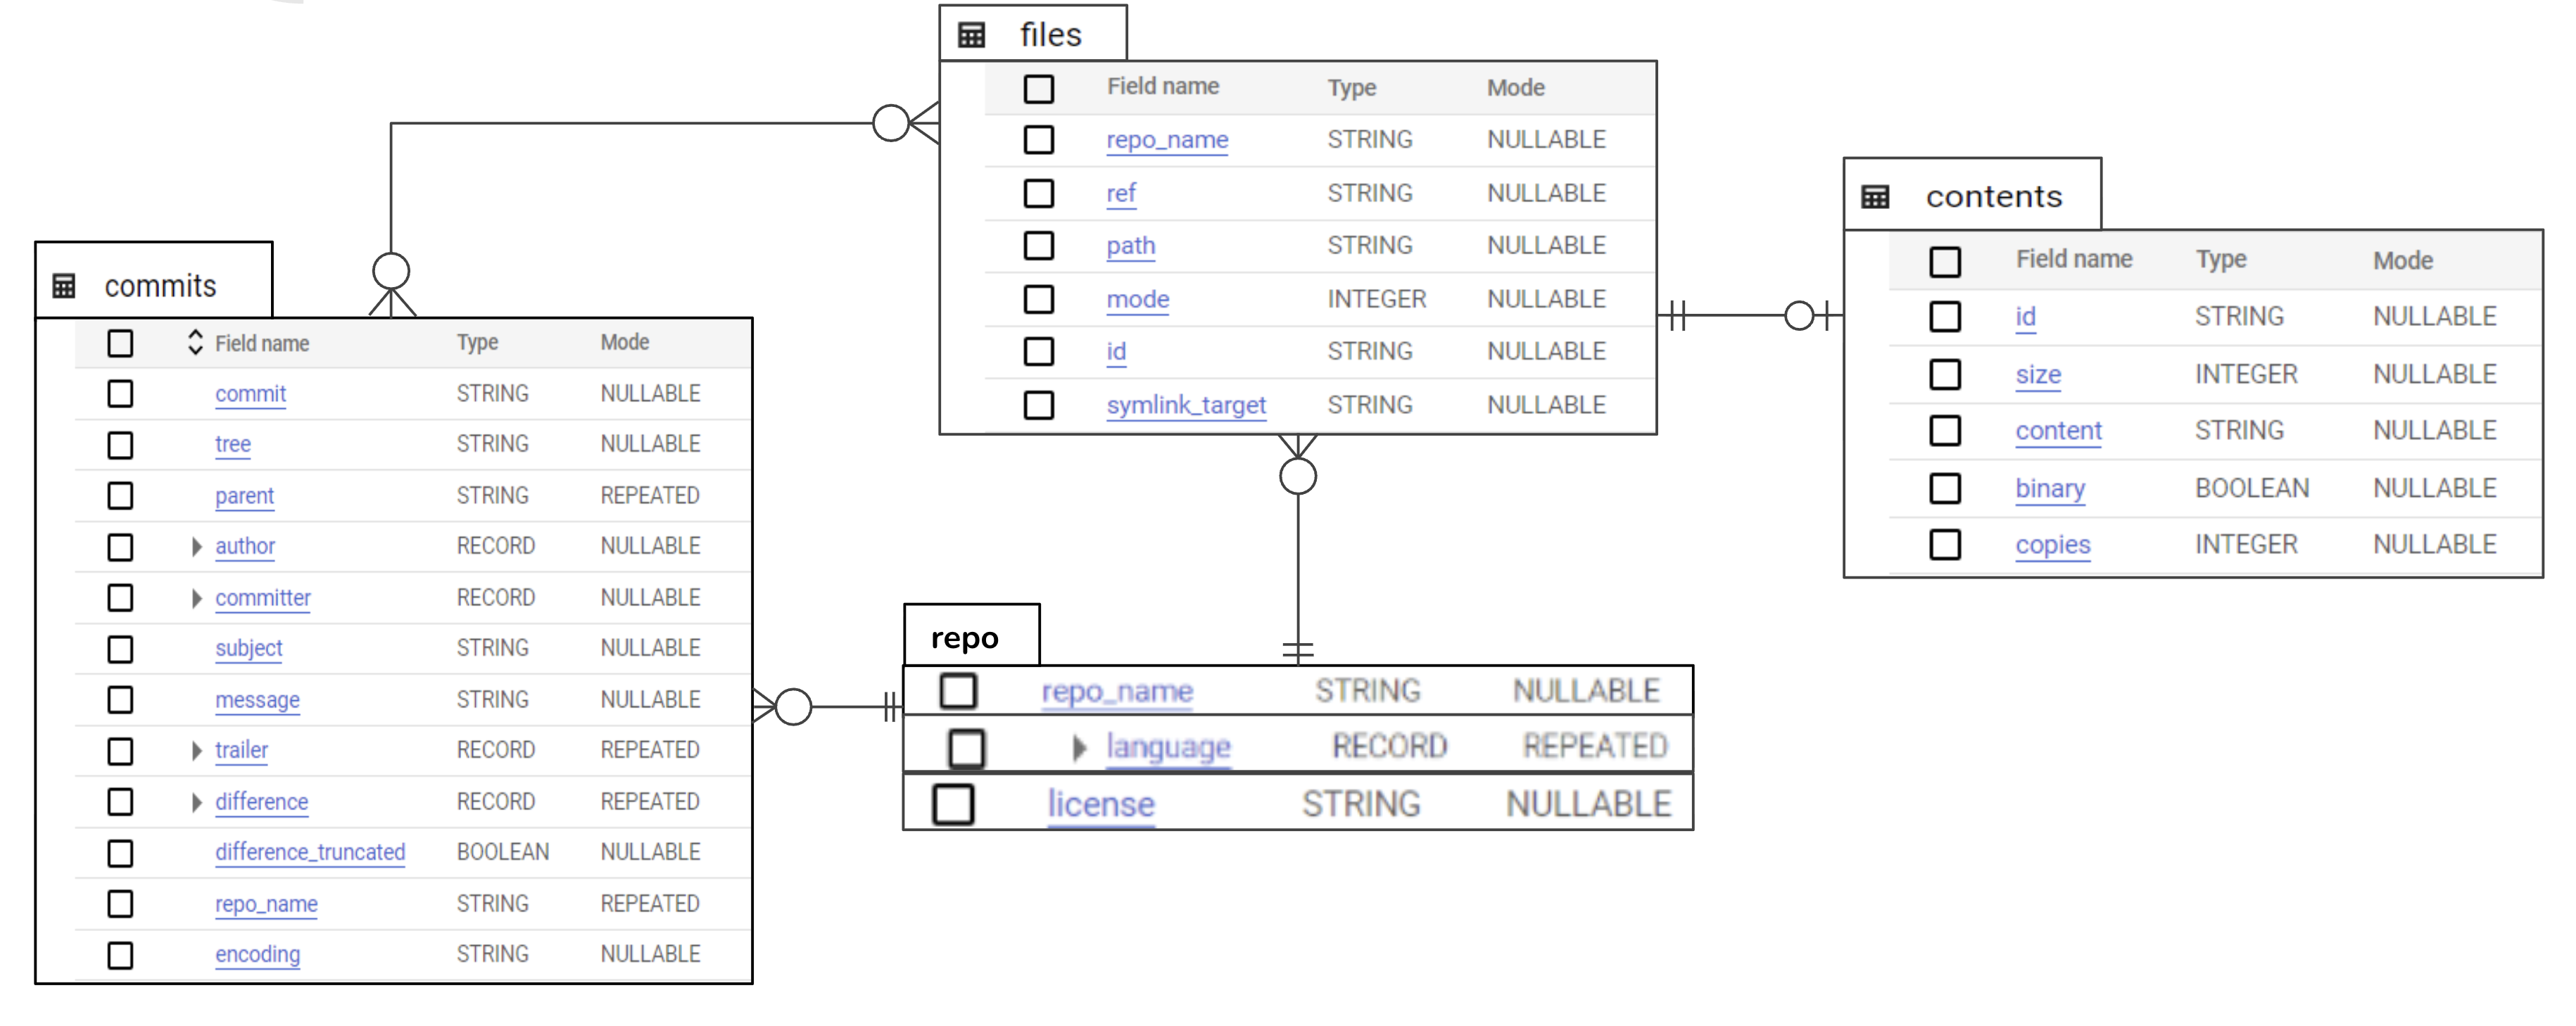

In [ ]:
display(Image("https://raw.githubusercontent.com/soltaniehha/Business-Analytics-Toolbox/master/docs/images/ERD-Example.png", width=800))

In [ ]:
def describe_test_image(image_path, prompt=DEFAULT_PROMPT):
    response = requests.get(image_path)
    image = PIL.Image.open(BytesIO(response.content))
    text, usage = describe_image(image, prompt)
    print(text)
    return text, usage

# Example (uncomment and update the path):
image_description, usage = describe_test_image("https://raw.githubusercontent.com/soltaniehha/Business-Analytics-Toolbox/master/docs/images/ERD-Example.png")
Markdown(image_description)
print(usage)

Overview
- This image is an entity-relationship style schema diagram showing four data tables (commits, files, contents, repo) and the relationships between them.

Key objects (entities) and layout
- commits (large box, left)
- files (box, top center)
- contents (box, right)
- repo (small box, bottom center)
- Visual style: each entity is a rectangular table with a header (table name and small table icon) and a column list showing Field name, Type, Mode. Field names appear as blue links; types and modes are gray. Checkboxes appear at left of each row. Connectors with multiplicity glyphs join the tables.

Detailed attributes (as visually shown)
- commits
  - Fields (visible): commit (STRING NULLABLE), tree (STRING NULLABLE), parent (STRING REPEATED), author (RECORD NULLABLE), committer (RECORD NULLABLE), subject (STRING NULLABLE), message (STRING NULLABLE), trailer (RECORD REPEATED), difference (RECORD REPEATED), difference_truncated (BOOLEAN NULLABLE), repo_name (STRING REPEATED), enco

## Gradio Demo
Upload an image, optionally tweak the prompt, and share the demo link if needed.

In [ ]:
def describe_with_prompt(image, prompt):
    return describe_image(image, prompt or DEFAULT_PROMPT)[0]


demo = gr.Interface(
    fn=describe_with_prompt,
    inputs=[
        gr.Image(type="pil", label="Upload an image"),
        gr.Textbox(label="Prompt", value=DEFAULT_PROMPT, lines=3),
    ],
    outputs=gr.Textbox(label="Vision model response", lines=30),
    title="🦉 Professor Owl – Technical Image Explainer",
    description=f"Upload a technical image and let {MODEL} describe it in natural language.",
)


demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f17a1572dfb46a5ddc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Your Turn
Plug in your own scenario: Rephrase the instructions to shift tone/guidelines.

In [ ]:
# Your code goes here